In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
from scprint.tasks.cell_emb import display_confusion_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
from scdataloader.utils import translate
import bionty as bt
from scprint.tasks.cell_emb import compute_classification

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from scdataloader import SimpleAnnDataset, Collator, DataModule
from torch.utils.data import DataLoader

import lamindb as ln

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../1lzuxvg0.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [3]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


FYI: scPrint is not attached to a `Trainer`.


In [2]:
da = sc.read("./data/task_3_embed.h5ad")

In [5]:
map_to_val = {n: i for i, n in enumerate(set(da.obs["batch"].unique()))}
da.obs["batch"] = da.obs["batch"].map(map_to_val)

In [6]:
# Prepare data for fine-tuning (using the cat/tiger dataset from above)
# Split data into train/val
n_train = int(0.8 * len(da))
train_idx = np.random.choice(len(da), n_train, replace=False)
val_idx = np.setdiff1d(np.arange(len(da)), train_idx)

train_data = da[train_idx].copy()
val_data = da[val_idx].copy()

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

mencoders = {}
for k, v in model.label_decoders.items():
    mencoders[k] = {va: ke for ke, va in v.items()}
# this needs to remain its original name as it is expect like that by collator, otherwise need to send org_to_id as params
mencoders.pop("organism_ontology_term_id")

# Create datasets
train_dataset = SimpleAnnDataset(
    train_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

val_dataset = SimpleAnnDataset(
    val_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

# Create collator
collator = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    class_names=["cell_type_ontology_term_id", "batch"],
    how="random expr",  # or "all expr" for full expression
    max_len=3000,
    add_zero_genes=0,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    collate_fn=collator,
    batch_size=32,  # Adjust based on GPU memory
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    collate_fn=collator,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
)

Training data: (21760, 57186)
Validation data: (5440, 57186)


In [7]:
d_model_ct = 64  # dimension for cell type classification

batch_cls = torch.nn.Sequential(
    torch.nn.Linear(d_model_ct, d_model_ct),
    torch.nn.ReLU(),
    torch.nn.Linear(d_model_ct, len(set(da.obs["batch"].unique()))),
)
batch_cls = batch_cls.to(model.device)

# Create a learnable embedding vector of size d_model
batch_vector = torch.nn.Embedding(
    num_embeddings=2, embedding_dim=model.class_encoder.embedding.weight.shape[1]
).to(model.device)

In [8]:
for val in model.parameters():
    val.requires_grad = False
for val in model.cell_transformer.parameters():
    val.requires_grad = True
for val in model.transformer.blocks[7].parameters():
    val.requires_grad = True
for i in model.transformer.blocks:
    i.cross_attn.requires_grad = True
for val in model.compressor.parameters():
    val.requires_grad = True
for val in model.cls_decoders["cell_type_ontology_term_id"].parameters():
    val.requires_grad = True

In [9]:
# Alternative: Manual Training Loop (for more control)
# If you prefer to have more control over the training process
from tqdm import tqdm
import torch.nn.functional as F
from scprint.model import loss

num_epochs = 20
lr = 0.0004

# Setup optimizer
all_params = (
    list(model.parameters())
    + list(batch_cls.parameters())
    + list(batch_vector.parameters())
)
optimizer = torch.optim.AdamW(
    all_params, lr=lr, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Setup automatic mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

_ = model.train()

for k, i in model.mat_labels_hierarchy.items():
    model.mat_labels_hierarchy[k] = i.to(model.device)

/tmp/ipykernel_3376291/1547507409.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [10]:
def batch_corr_pass(batch):
    gene_pos = batch["genes"].to(model.device)
    expression = batch["x"].to(model.device)
    depth = batch["depth"].to(model.device)
    class_elem = batch["class"].long().to(model.device)

    # Forward pass with automatic mixed precisio^n
    with torch.cuda.amp.autocast():
        # Forward pass
        output = model.forward(
            gene_pos,
            expression,
            req_depth=depth,
            depth_mult=expression.sum(1),
            do_class=True,
            metacell_token=torch.zeros_like(depth),
        )

        output["output_cell_embs"][
            :, model.classes.index("organism_ontology_term_id") + 1, :
        ] = batch_vector(class_elem[:, 1])
        output_gen = model._generate(
            cell_embs=output["output_cell_embs"],
            gene_pos=gene_pos,
            depth_mult=expression.sum(1),
            req_depth=depth,
        )
        # model.qkv # use it to fine tune on the gene interactions
        # predict something like known PPI matrices, cell specific GRNs from atac-seq data

        # model.gene_output_embeddings
        # use it to train a classifier on top to predict other modalities from gene embeddings given an additional anndata
        # could be protein expression, ATAC-seq gene activity, transcript dynamics

        # model.gen_output["expression"] # modify the loss so that the model learns to predict KO given additional gene + with learnt KO representation token
        # or expression temporal change given learnt temporal token

        # for batch correction and classification
        # Compute losses
        total_loss = 0

        if "zero_logits" in output_gen:
            loss_expr = loss.zinb(
                theta=output_gen["disp"],
                pi=output_gen["zero_logits"],
                mu=output_gen["mean"],
                target=expression,
            )
            if model.zinb_and_mse:
                loss_expr += (
                    loss.mse(
                        input=torch.log(output_gen["mean"] + 1)
                        * (1 - torch.sigmoid(output_gen["zero_logits"])),
                        target=torch.log(expression + 1),
                    )
                    / 10  # scale to make it more similar to the zinb
                )
        else:
            loss_expr = loss.mse(
                input=torch.log(output_gen["mean"] + 1),
                target=torch.log(expression + 1),
            )

        # Add expression loss to total
        total_loss += loss_expr

        # Classification loss
        cls_output = output.get("cls_output_cell_type_ontology_term_id")
        if cls_output is not None:
            cls_loss = loss.hierarchical_classification(
                pred=cls_output,
                cl=batch["class"][:, 0].to(model.device),
                labels_hierarchy=model.mat_labels_hierarchy.get(
                    "cell_type_ontology_term_id"
                ).to("cuda"),
            )
            total_loss += cls_loss

        pos = model.classes.index("cell_type_ontology_term_id") + 1
        # Apply gradient reversal to the input embedding
        selected_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        adv_input_emb = loss.grad_reverse(selected_emb.clone(), lambd=1.0)
        # Get predictions from the adversarial decoder
        adv_pred = batch_cls(adv_input_emb)
        # do dissim

        # Compute the adversarial loss - Fix: Convert target to long type
        current_adv_loss = torch.nn.functional.cross_entropy(
            input=adv_pred,
            target=class_elem[:, 1],  # Convert to long type
        )

        # Add adversarial loss to total loss
        total_loss += current_adv_loss
        total_loss += output["vae_kl_loss"] * 0.5
    return total_loss, cls_loss, current_adv_loss, loss_expr

In [11]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0

    # pbar = tqdm(train_loader, desc="Training")
    for batch_idx, batch in enumerate(train_loader):
        # if epoch == 0:
        #    break
        # Move batch to device
        optimizer.zero_grad()
        total_loss, cls_loss, current_adv_loss, loss_expr = batch_corr_pass(batch)
        # Backward pass
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += total_loss.item() if not torch.isnan(total_loss) else 0
        train_steps += 1
        avg_cls += cls_loss.item() if not torch.isnan(cls_loss) else 0
        avg_expr += loss_expr.item() if not torch.isnan(loss_expr) else 0
        avg_adv += current_adv_loss.item() if not torch.isnan(current_adv_loss) else 0
        # Update progress bar
        # if batch_idx % 35 == 0:
        # print(
        #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_adv / train_steps:.4f}"
        # )
        # pbar.set_postfix(
        #    {
        #        "loss": f"{total_loss.item():.4f}",
        #        "avg_loss": f"{train_loss / train_steps:.4f}",
        #        "lr": f"{optimizer.param_groups[0]['lr']:.2e}",
        #        "cls_loss": f"{cls_loss.item():.4f}",
        #        "adv_loss": f"{current_adv_loss.item():.4f}",
        #        "expr_loss": f"{loss_expr.item():.4f}",
        #    }
        # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # , desc="Validation"):
            loss_val, cls_loss, current_adv_loss, loss_expr = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item() - (2 * current_adv_loss.item())
            val_loss += loss_val.item()
            val_steps += 1
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, adv_loss: {:.4f}, expr_loss: {:.4f}".format(
            cls_loss.item(), current_adv_loss.item(), loss_expr.item()
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Early stopping check (simple implementation)
    if epoch > 10 and val_loss / val_steps > 1.3 * avg_train_loss:
        print("Early stopping due to overfitting")
        break

print("Manual fine-tuning completed!")


Epoch 1/20


/tmp/ipykernel_3376291/1364166827.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


cls_loss: 0.0113, adv_loss: 0.5610, expr_loss: 0.9206
Train Loss: 1.7406, Val Loss: 0.2617

Epoch 2/20


cls_loss: 0.0098, adv_loss: 0.5392, expr_loss: 0.8842
Train Loss: 1.6301, Val Loss: 0.2459

Epoch 3/20


cls_loss: 0.0053, adv_loss: 0.5147, expr_loss: 0.8788
Train Loss: 1.5979, Val Loss: 0.2290

Epoch 4/20


cls_loss: 0.0055, adv_loss: 0.5350, expr_loss: 0.8759
Train Loss: 1.5885, Val Loss: 0.2247

Epoch 5/20


cls_loss: 0.0034, adv_loss: 0.5156, expr_loss: 0.8725
Train Loss: 1.5829, Val Loss: 0.2189

Epoch 6/20


cls_loss: 0.0072, adv_loss: 0.5096, expr_loss: 0.8697
Train Loss: 1.5822, Val Loss: 0.1991

Epoch 7/20


cls_loss: 0.0046, adv_loss: 0.5330, expr_loss: 0.8689
Train Loss: 1.5767, Val Loss: 0.2095

Epoch 8/20


cls_loss: 0.0042, adv_loss: 0.5854, expr_loss: 0.8671
Train Loss: 1.5746, Val Loss: 0.1832

Epoch 9/20


cls_loss: 0.0038, adv_loss: 0.5099, expr_loss: 0.8686
Train Loss: 1.5833, Val Loss: 0.2129

Epoch 10/20


cls_loss: 0.0036, adv_loss: 0.5170, expr_loss: 0.8674
Train Loss: 1.5735, Val Loss: 0.2140

Epoch 11/20


cls_loss: 0.0031, adv_loss: 0.5199, expr_loss: 0.8653
Train Loss: 1.5714, Val Loss: 0.2118

Epoch 12/20


cls_loss: 0.0034, adv_loss: 0.5148, expr_loss: 0.8625
Train Loss: 1.5655, Val Loss: 0.2112

Epoch 13/20


cls_loss: 0.0026, adv_loss: 0.5199, expr_loss: 0.8624
Train Loss: 1.5644, Val Loss: 0.2074

Epoch 14/20


cls_loss: 0.0034, adv_loss: 0.5208, expr_loss: 0.8636
Train Loss: 1.5643, Val Loss: 0.2045

Epoch 15/20


cls_loss: 0.0021, adv_loss: 0.5200, expr_loss: 0.8633
Train Loss: 1.5623, Val Loss: 0.2069

Epoch 16/20


cls_loss: 0.0010, adv_loss: 0.5209, expr_loss: 0.8616
Train Loss: 1.5601, Val Loss: 0.2062

Epoch 17/20


cls_loss: 0.0018, adv_loss: 0.5188, expr_loss: 0.8613
Train Loss: 1.5600, Val Loss: 0.2091

Epoch 18/20


cls_loss: 0.0013, adv_loss: 0.5177, expr_loss: 0.8612
Train Loss: 1.5576, Val Loss: 0.2082

Epoch 19/20


cls_loss: 0.0019, adv_loss: 0.5178, expr_loss: 0.8622
Train Loss: 1.5575, Val Loss: 0.2097

Epoch 20/20


cls_loss: 0.0014, adv_loss: 0.5186, expr_loss: 0.8611
Train Loss: 1.5580, Val Loss: 0.2088
Manual fine-tuning completed!


In [12]:
epoch = 10
batch_idx = 680

In [13]:
import lightning as L

checkpoint = {
    "epoch": epoch,
    "global_step": (1 + epoch) * batch_idx,
    "pytorch-lightning_version": L.__version__,
    "state_dict": model.state_dict(),
    "optimizer_states": [optimizer.state_dict()],
    "lr_schedulers": [scheduler.state_dict()],
    "hparams_name": None,
    "loops": None,
    "callbacks": None,
    "hyper_parameters": model.hparams,
}
torch.save(checkpoint, "fit_2.ckpt")

In [14]:
# model.load_state_dict(torch.load("fit_2.ckpt")["state_dict"])

In [3]:
model = scPrint.load_from_checkpoint(
    "fit_2.ckpt", precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert
FYI: scPrint is not attached to a `Trainer`.


In [4]:
da.obs = da.obs.iloc[:, :-15]
for i in [
    "scprint_emb",
    "scprint_emb_age_group",
    "scprint_emb_assay_ontology_term_id",
    "scprint_emb_cell_culture",
    "scprint_emb_cell_type_ontology_term_id",
    "scprint_emb_disease_ontology_term_id",
    "scprint_emb_organism_ontology_term_id",
    "scprint_emb_other",
    "scprint_emb_self_reported_ethnicity_ontology_term_id",
    "scprint_emb_sex_ontology_term_id",
    "scprint_emb_tissue_ontology_term_id",
]:
    da.obsm.pop(i)

In [5]:
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)

In [6]:
n_adata, metrics = embed(model, da.copy())

not on wandb, could not set name


100%|██████████| 425/425 [01:16<00:00,  5.58it/s]


logging the anndata


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)
/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)
/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)
/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: 

AnnData object with n_obs × n_vars = 27200 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [19]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': np.float64(0.7681617647058824),
  'macro': 0.7442039906720689,
  'micro': 0.7681617647058824,
  'weighted': 0.7283662133965179}}

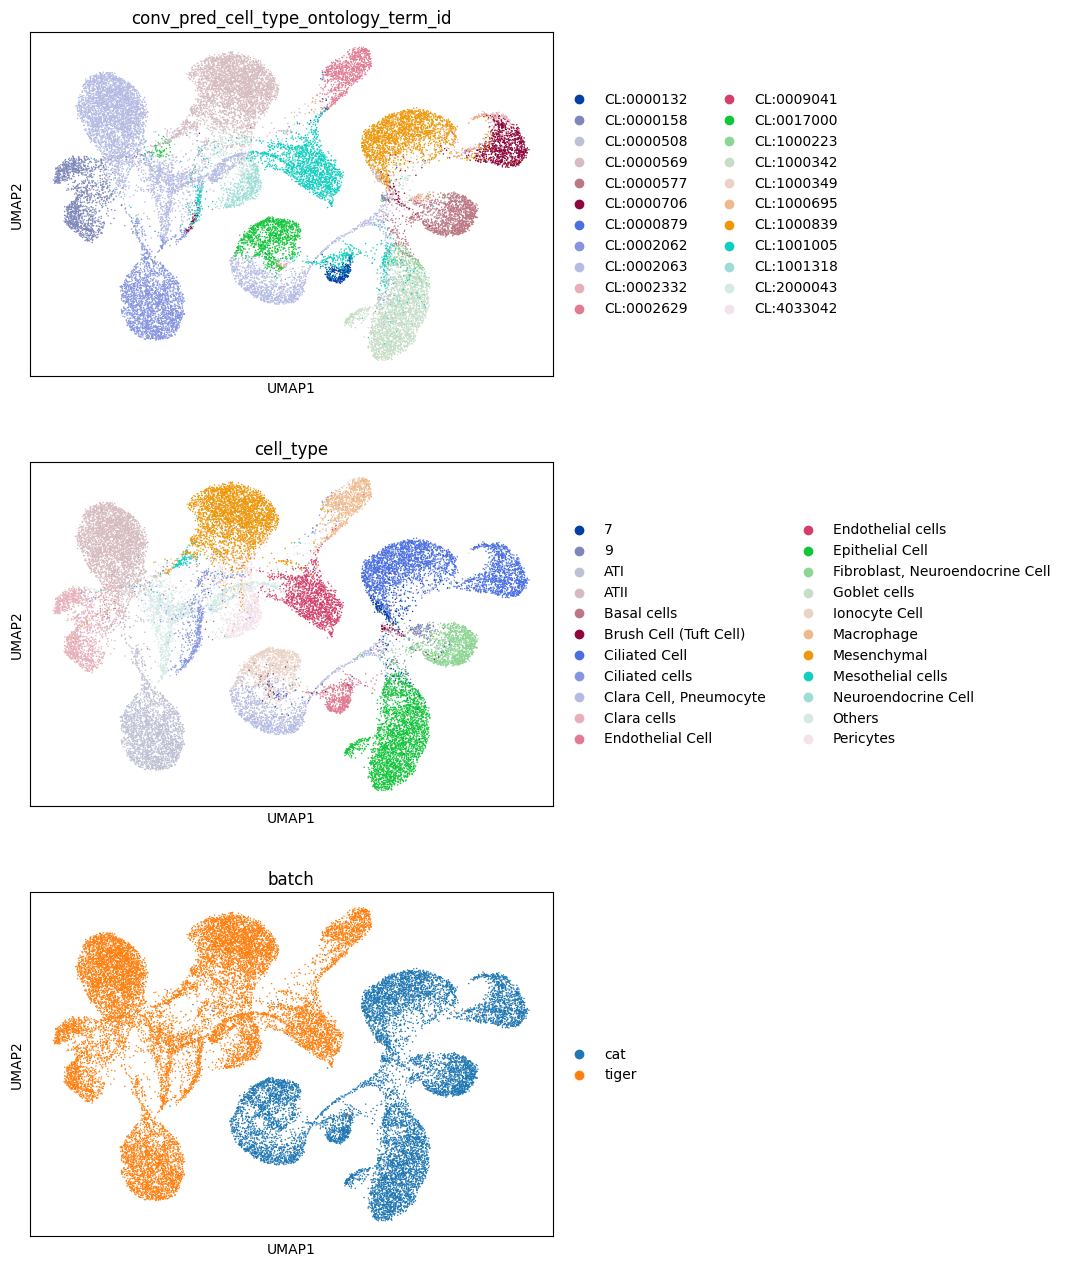

In [7]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

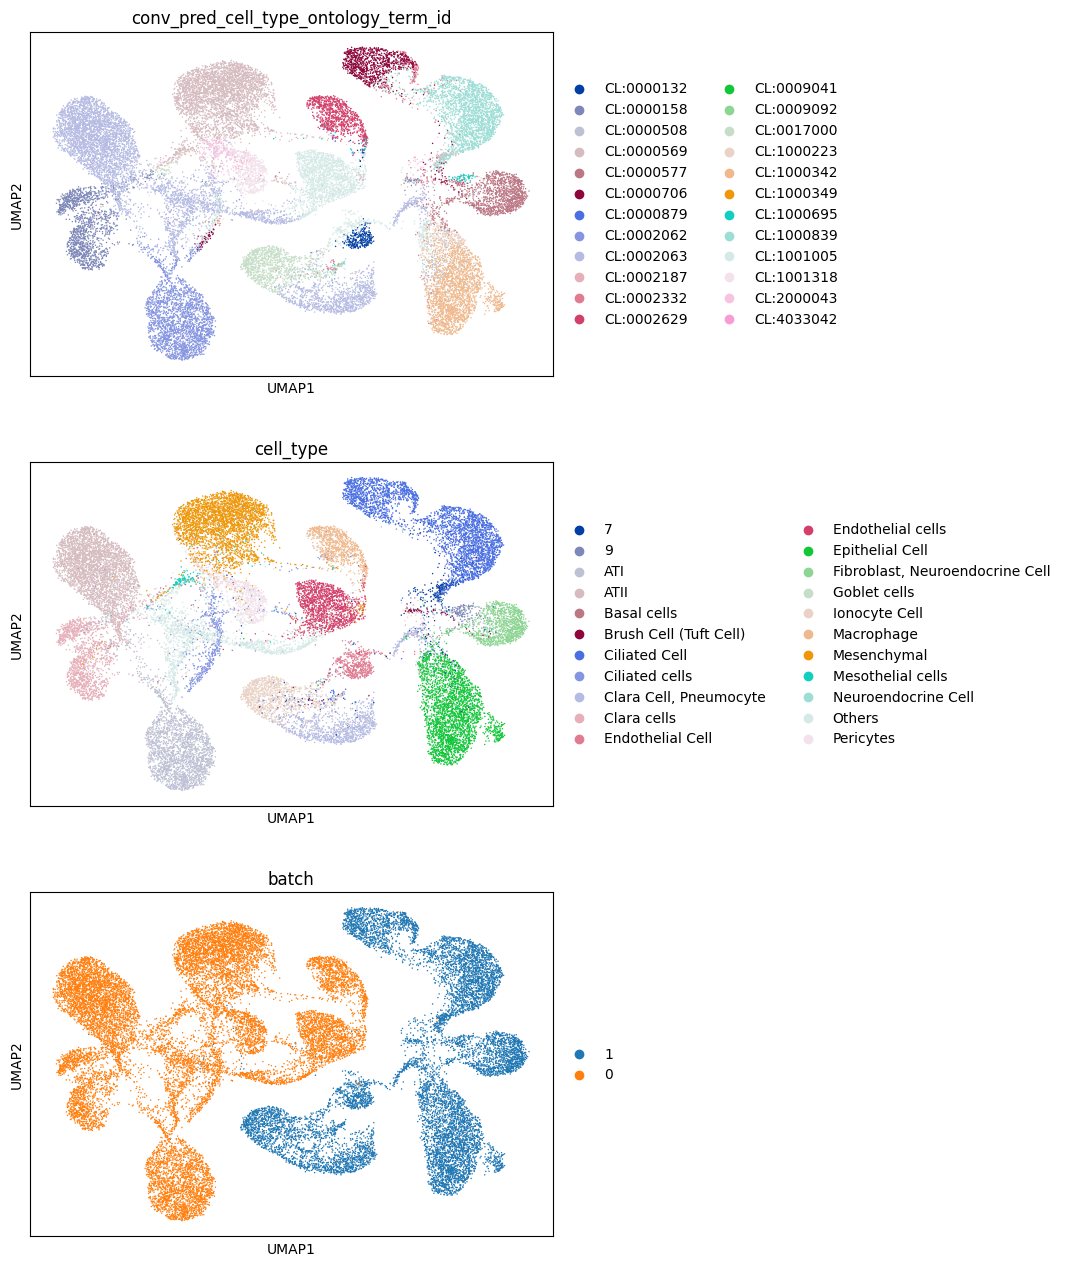

In [20]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

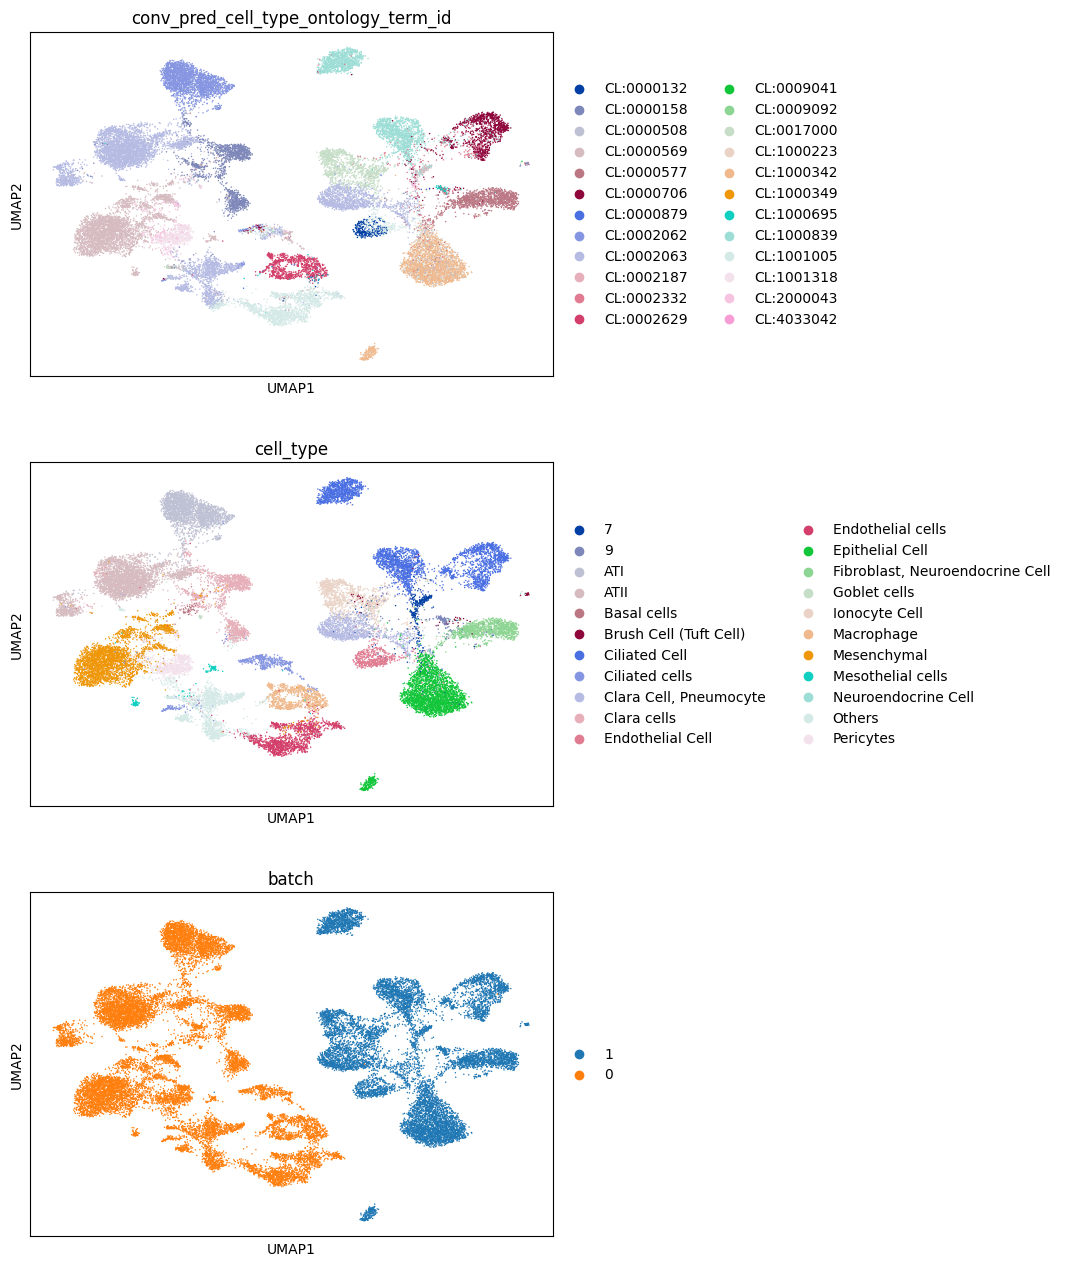

In [21]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

In [8]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb_cell_type_ontology_term_id"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]Tue Sep  9 10:34:35 2025 INFO isolated labels: no more than 1 batches per label
INFO:2025-09-09 10:34:35,605:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Tue Sep  9 10:34:35 2025 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Tue Sep  9 10:34:35 2025 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not 

INFO     CL:0000064 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000066 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000158 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000165 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000235 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000322 consists of a single batch or is too small. Skip.                                              
INFO     CL:0000669 consists of a single batch or is too small. Skip.                                              
INFO     CL:0002062 consists of a single batch or is too small. Skip.                                              
INFO     CL:0002063 consists of a single batch or is too small. Skip.   

Metrics:  70%|███████   | 7/10 [01:46<00:24,  8.33s/it, Batch correction: kbet_per_label]/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [01:48<00:00, 108.35s/it]


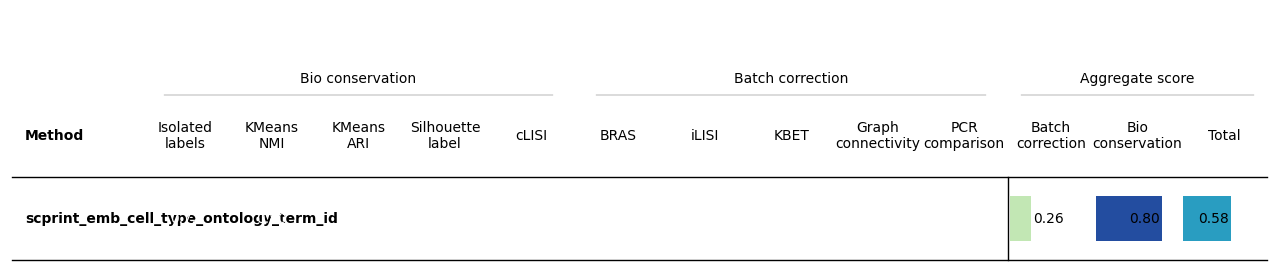

In [9]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)

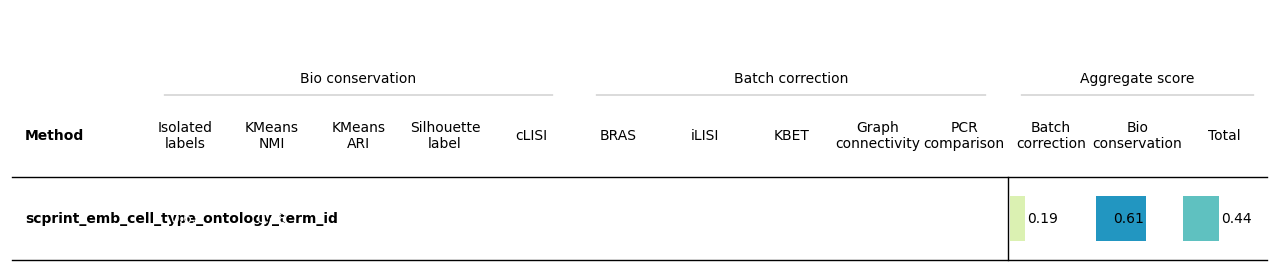

In [23]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)